# Instrumental Variable, 2SLS, and Local Average Treatment Effect (LATE)

Prof. Daniel de Abreu Pereira Uhr


### Estrutura da aula

* Revisando o estimador Tradicional de IV/2SLS e o viés de variável omitida
* Considerações gerais sobre o estimador tradicional de IV/2SLS 
* Aplicação do 2SLS em Python
  * Angrist e Krueger ( 1991 )
* Local Average Treatment Effect (LATE)
* Formalizando o Local Average Treatment Effect (LATE)
* Aplicação do IV/LATE em Python 2
* Considerações 

### Referências

* Cunningham, S. W. (2013). Causal inference: The mixtape. https://www.scunning.com/mixtape.html
* Facure, Matheus. Causal Inference for The Brave and True. https://matheusfacure.github.io/python-causality-handbook/landing-page.html 
* Joshua D. Angrist and Jörn-Steffen Pischke (2009). Mostly Harmless Econometrics: An Empiricist's Companion. Princeton University Press.
* Imbens, G. W., & Rubin, D. B. (2015). Causal inference in statistics, social, and biomedical sciences. Cambridge University Press.
* Itau Social (2018). Avaliação Econômica de Projetos Sociais. https://www.itausocial.org.br/wp-content/uploads/2018/05/avaliacao-economica-3a-ed_1513188151.pdf 
* Notas próprias


**Observações:** O material apresentado aqui é uma adaptação do material de aula do Prof. Daniel de Abreu Pereira Uhr, e não deve ser utilizado para fins comerciais. O material é disponibilizado para fins educacionais e de pesquisa, e não deve ser reproduzido sem a devida autorização do autor. Este material pode conter erros e imprecisões. O autor não se responsabiliza por quaisquer danos ou prejuízos decorrentes do uso deste material. O uso deste material é de responsabilidade exclusiva do usuário. Caso você encontre erros ou imprecisões neste material, por favor, entre em contato com o autor para que possam ser corrigidos. O autor agradece qualquer *feedback* ou sugestão de melhoria.

---

### Revisando o estimador Tradicional de IV/2SLS e o viés de variável omitida

Vimos que uma maneira de controlar o Viés de Variável Omitida é adicionar essa própria variável omitida ao modelo. No entanto, isso nem sempre é possível, principalmente porque simplesmente não temos dados sobre eventuais variáveis ​​omitidas. Por exemplo, considere o modelo de efeito da educação sobre os salários:

$$ ln(Salários)_{i} = \beta+{0} + \theta educ_{i} + \phi Habilidade_{i} + \epsilon_{i} $$

Para descobrir o efeito causal da educação $\theta$ sobre o $ln(salários)$ precisamos controlar os fatores de habilidade. Se não o fizermos, provavelmente teríamos algum viés, afinal, a capacidade é provavelmente um fator de confusão (confunding), causando tanto o tratamento, a educação, quanto o resultado, os ganhos salariais.

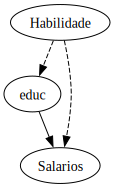

In [145]:
import graphviz as gr
g = gr.Digraph()
g.edge("Habilidade", "educ", style="dashed")
g.edge("Habilidade", "Salarios", style="dashed")
g.edge("educ", "Salarios")
g

Poderíamos controlar o caminho de porta dos fundos incluindo a habilidade em nosso modelo de regressão linear ("controlando o caminho de porta dos fundos"). No entanto, não temos boas medidas de capacidade. O melhor que temos são algumas *proxies* muito questionáveis, como, por exemplo, o teste de QI.

É aqui que as Variáveis ​​Instrumentais (VI) entram em cena. **A ideia da VI é encontrar outra variável que cause o tratamento e só esteja correlacionada com o resultado ao longo da variável de tratamento**. Outra forma de dizer isto é que este instrumento $Z_{i}$ não está correlacionado com $Y_{0}$, mas está correlacionado com $D$ (**restrição de exclusão**).

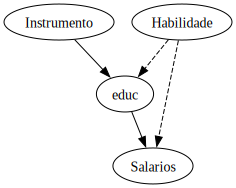

In [146]:
g = gr.Digraph()
g.edge("Habilidade", "educ", style="dashed")
g.edge("Habilidade", "Salarios", style="dashed")
g.edge("educ", "Salarios")
g.edge("Instrumento", "educ")
g

***Condições para uma variável ser um bom instrumento***

Então, as duas condições que definem uma variável como instrumento são: 

* **Primeira condição (Validade)**: 
  * precisamos de um **instrumento Válido** ($Z$), isto é, uma variável que não seja correlacionada com o termo de erro (com variáveis não observáveis contidas no termo de erro) [satisfazer a restrição de exclusão].

$$ 
\boxed{
Cov(Z,u)=0 
}
$$

**A primeira condição ($ 𝑪𝒐𝒗(𝒁,𝒖)=𝟎 $), não pode ser testada empiricamente.** Normalmente essa condição é argumentada teoricamente (para regressões com apenas uma variável instrumental). Assim, nos artigos são apresentadas as possíveis justificativas teóricas para suportar essa hipótese.

* **Segunda condição (Relevância)**: 
  * o instrumento ser correlacionado com a variável endógena, ou seja, exista relevância do instrumento (força)

$$
\boxed{
Cov(Z,D)  \neq  0
}
$$

Cabe destacar aqui que, normalmente, os "bons" instrumentos utilizados na literatura costumam ser recebidos com estranheza durante a primeira leitura. O instrumento normalmente parece não ter a mínima relação com o resultado de interesse (isso é bom, pois a restrição de exclusão é satisfeita). E o melhor instrumento é aquele que possui uma atribuição aleatória. Veremos isso durante os exemplos.

***Modelando o Viés de variável omitida***

Vamos continuar com nosso problema inicial. 

Se temos um instrumento, podemos recuperar o efeito causal $\theta$ relacionado à educação com o método IV. Para fazer isso, vamos pensar na equação ideal que queremos executar. Usando termos mais gerais como $D$ para o tratamento (educ) e $W$ para os confundidores (habilidade), aqui está o modelo linear que queremos identificar:

$$ Y_{i} = \beta_{0} + \theta D_{i} + \phi W_{i} + u_{i} $$

Como não temos dados para $W$, então nos deparamos com o seguinte modelo:

$$ Y_{i} = \beta_{0} + \theta D_{i} + v_{i} $$

$$ v_{i} = \phi W_{i} + u_{i} $$

Como $W$ é um confundidor, $Cov(D,v) \neq 0$. Isso significaria que a habilidade está correlacionada com a educação (endogeneidade). Executar a regressão com variável relevante omitida produziria um estimador viesado para $\theta$ devido a variáveis ​​omitidas (**Viés de variável omitida**).

***Estimador Tradicional de IV/2SLS***

Como o instrumento $Z$ só está correlacionado com o resultado ($Y$) através de $D$, isso implica que $Cov(Z,v) = 0$, caso contrário, haveria um segundo caminho de $Z$ para $Y$ através de $W$. 

Vejamos o caminho da relação entre o instrumento e a variável de resposta::

$$ Cov(Z,Y) = Cov(Z,\beta_{0} + \theta D + v_{i}) = \theta . Cov(Z,D) + Cov(Z,v) = \theta Cov(Z,D) $$

Dividindo cada lado por $V(Z_{i})$, e reorganizando, obtemos:

$$ \theta = \frac{Cov(Z,Y)/V(Z_{i})}{Cov(Z,D)/V(Z_{i})} = \frac{\text{Forma Reduzida}}{\text{Primeiro Estágio}} $$


Tanto o **numerador quanto o denominador são coeficientes de regressão** (covariâncias divididas por variâncias). 

* **O numerador é o resultado da regressão de $Y$ sobre $Z$**. Em outras palavras, é o “impacto” de $Z$ sobre $Y$. Lembre-se de que isso não quer dizer que $Z$ causa $Y$, pois temos a exigência de que $Z$ impacte $Y$ apenas por meio de $D$. Em vez disso, ele está apenas capturando o quão grande é esse efeito de $Z$ em $Y$ através de $D$. Esse numerador é tão famoso que tem seu próprio nome: **coeficiente da forma reduzida**.

* **O denominador também é um coeficiente de regressão**. Desta vez, é a regressão de $Z$ sobre $D$. Essa regressão capta qual é o impacto de $Z$ sobre $D$ e também é tão famosa que é chamada de **coeficiente do Primeiro Estágio**.

Outra maneira interessante de analisar esta equação é em termos de derivadas parciais. Podemos mostrar que o impacto de $D$ sobre $Y$ é igual ao impacto de $Z$ sobre $Y$, dimensionado pelo impacto de $Z$ sobre $D$:

$$ \theta = \frac{\frac{\partial y}{\partial z}}{\frac{\partial D}{\partial z}} = \frac{\partial y}{\partial z}*\frac{\partial z}{\partial D} = \frac{\partial y}{\partial D} $$

Ao escrever IV dessa forma, estamos dizendo: “é difícil encontrar o impacto de $D$ em $Y$ devido a fatores de confusão. Mas podemos encontrar facilmente o impacto de $Z$ em $Y$, já que não há nada que cause $Z$ e $Y$ (***devido à restrição de exclusão***). 

No entanto, estamos interessados no impacto de $D$ em $Y$, não de $Z$ em $Y$. Portanto, estimarei o efeito fácil de $Z$ em $Y$ e dimensionarei pelo efeito de $Z$ em $D$ , para converter o efeito em unidades $D$ em vez de unidades $Z$”.


***Estimador de Wald***

Também podemos ver isto pela razão entre 2 diferenças nas médias.

$$ \theta = \frac{E[Y|Z=1]-E[Y|Z=0]}{E[D|Z=1]-E[D|Z=0]} $$

Essa proporção é chamada de **Estimador de Wald**. 

Novamente, podemos contar a história do IV onde queremos o efeito de $D$ sobre $Y$, o que é difícil de obter. Então nos concentramos no efeito de $Z$ sobre $Y$, o que é fácil. Por definição, $Z$ afeta apenas $Y$ através de $D$, então agora podemos converter o impacto de $Z$ sobre $Y$ no impacto de $D$ sobre $Y$. Fazemos isso escalonando o efeito de $Z$ sobre $Y$ pelo efeito de $Z$ sobre $D$.

Como ponto de partida, você pode obter a identificação causal usando IV somente se puder defender teórica e logicamente a **restrição de exclusão**, já que a **restrição de exclusão é uma suposição não testável**. Essa defesa requer teoria, e já que algumas pessoas não se sentem confortáveis ​​com argumentos teóricos como esse, elas tendem a evitar o uso de IV.

**Muitos microeconomistas aplicados são céticos em relação a IV** porque eles são capazes de contar histórias ilimitadas nas quais as restrições de exclusão não se sustentam.

**Quarde isso em mente, normalmente, os instrumentos são estranhos, isso é, as pessoas ficam confusas quando você fala sobre a relação do instrumento com o resultado**. 

#### Considerações gerais sobre o estimador tradicional de IV/2SLS 

* Hipótese de identificação: viés devido a características não observadas (variável omitida/ confounding).
* Supomos que o efeito do tratamento é homogêneo (não há efeito heterogêneo).
* Supomos que o instrumento é válido (excluído da equação de regressão/ respeita a restrição de exclusão).
* Supomos que o instrumento é forte (tem um efeito relevante sobre o tratamento).

### Aplicação do 2SLS em Python

* Pacotes instalados: Kernel Python 3.11.5
* Importando as bibliotecas necessárias e carregando os dados:

In [1]:
import pandas as pd
import linearmodels.iv.model as lm

In [3]:
# DataFrame
data = pd.read_csv("https://github.com/Daniel-Uhr/data/raw/main/ak91.csv")
data.head()

,log_wage,years_of_schooling,year_of_birth,quarter_of_birth,state_of_birth
0,5.790019,12.0,30.0,1.0,45.0
1,5.952494,11.0,30.0,1.0,45.0
2,5.315949,12.0,30.0,1.0,45.0
3,5.595926,12.0,30.0,1.0,45.0
4,6.068915,12.0,30.0,1.0,37.0


In [4]:
# Criar as variáveis dummies
data['q1'] = (data['quarter_of_birth'] == 1.0).astype(int)
data['q2'] = (data['quarter_of_birth'] == 2.0).astype(int)
data['q3'] = (data['quarter_of_birth'] == 3.0).astype(int)
data['q4'] = (data['quarter_of_birth'] == 4.0).astype(int)

Vamos fazer OLS sem considerar a endogeneidade para ter uma noção do resultado enviesado.

In [5]:
ols1 = lm.IV2SLS.from_formula("log_wage ~ 1 + years_of_schooling ", data).fit()
ols1.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,4.9952,0.0051,984.49,0.0000,4.9852,5.0051
years_of_schooling,0.0709,0.0004,185.95,0.0000,0.0701,0.0716


In [6]:
ols2 = lm.IV2SLS.from_formula("log_wage ~ 1 + years_of_schooling + C(year_of_birth)", data).fit()
ols2.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,5.0173,0.0060,833.65,0.0000,5.0056,5.0291
years_of_schooling,0.0711,0.0004,186.34,0.0000,0.0703,0.0718
C(year_of_birth)[T.31.0],-0.0064,0.0051,-1.2467,0.2125,-0.0164,0.0037
C(year_of_birth)[T.32.0],-0.0148,0.0051,-2.9371,0.0033,-0.0247,-0.0049
C(year_of_birth)[T.33.0],-0.0176,0.0051,-3.4692,0.0005,-0.0275,-0.0076
C(year_of_birth)[T.34.0],-0.0210,0.0051,-4.1484,0.0000,-0.0309,-0.0111
C(year_of_birth)[T.35.0],-0.0329,0.0050,-6.5275,0.0000,-0.0428,-0.0230
C(year_of_birth)[T.36.0],-0.0318,0.0050,-6.3943,0.0000,-0.0415,-0.0220
C(year_of_birth)[T.37.0],-0.0367,0.0049,-7.5008,0.0000,-0.0463,-0.0271
C(year_of_birth)[T.38.0],-0.0369,0.0049,-7.5964,0.0000,-0.0464,-0.0274


Vamos verificar o primeiro estágio da regressão, e verificar se os instrumentos estão correlacionados com a variável endógena (segunda condição). Repare que a variável dependente aqui é a escolaridade.

In [7]:
ols3 = lm.IV2SLS.from_formula("years_of_schooling ~ q1 + q2 + q3 + C(year_of_birth)", data).fit()
ols3.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,12.524,0.0212,590.61,0.0000,12.483,12.566
q1,-0.1485,0.0162,-9.1584,0.0000,-0.1803,-0.1167
q2,-0.0918,0.0163,-5.6176,0.0000,-0.1239,-0.0598
q3,-0.0357,0.0158,-2.2529,0.0243,-0.0667,-0.0046
C(year_of_birth)[T.31.0],0.1383,0.0269,5.1385,0.0000,0.0856,0.1911
C(year_of_birth)[T.32.0],0.1770,0.0266,6.6471,0.0000,0.1248,0.2292
C(year_of_birth)[T.33.0],0.2336,0.0268,8.7255,0.0000,0.1811,0.2861
C(year_of_birth)[T.34.0],0.2637,0.0264,10.001,0.0000,0.2121,0.3154
C(year_of_birth)[T.35.0],0.3279,0.0260,12.615,0.0000,0.2769,0.3788
C(year_of_birth)[T.36.0],0.3867,0.0258,15.009,0.0000,0.3362,0.4372


Certo, agora vamos realizar a análise através do estimador 2SLS, primeiramente sem covariáveis. E posteriormente adicionamos as covariáveis.

In [8]:
IV1 = lm.IV2SLS.from_formula("log_wage ~ 1 + [years_of_schooling ~ q1 + q2 + q3 ]", data).fit()
IV1.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,4.5898,0.2494,18.404,0.0000,4.1010,5.0786
years_of_schooling,0.1026,0.0195,5.2539,0.0000,0.0643,0.1409


Certo, agora vamos realizar a análise através do estimador 2SLS, agora consideramos as covariáveis "year_of_birth"

In [9]:
IV2 = lm.IV2SLS.from_formula("log_wage ~ 1 + [years_of_schooling ~ q1 + q2 + q3 ] + C(year_of_birth)", data).fit()
IV2.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,4.5917,0.2506,18.325,0.0000,4.1006,5.0829
C(year_of_birth)[T.31.0],-0.0111,0.0059,-1.8817,0.0599,-0.0227,0.0005
C(year_of_birth)[T.32.0],-0.0209,0.0062,-3.3542,0.0008,-0.0331,-0.0087
C(year_of_birth)[T.33.0],-0.0256,0.0070,-3.6645,0.0002,-0.0392,-0.0119
C(year_of_birth)[T.34.0],-0.0301,0.0074,-4.0525,0.0001,-0.0446,-0.0155
C(year_of_birth)[T.35.0],-0.0441,0.0084,-5.2776,0.0000,-0.0605,-0.0277
C(year_of_birth)[T.36.0],-0.0450,0.0093,-4.8391,0.0000,-0.0632,-0.0268
C(year_of_birth)[T.37.0],-0.0521,0.0103,-5.0381,0.0000,-0.0723,-0.0318
C(year_of_birth)[T.38.0],-0.0552,0.0118,-4.6609,0.0000,-0.0784,-0.0320
C(year_of_birth)[T.39.0],-0.0678,0.0126,-5.3858,0.0000,-0.0925,-0.0431


In [10]:
IV3 = lm.IV2SLS.from_formula("log_wage ~ 1 + [years_of_schooling ~ q1 + q2 + q3] + C(year_of_birth) + C(state_of_birth)", data).fit()
IV3.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,4.4924,0.2224,20.197,0.0000,4.0564,4.9283
C(year_of_birth)[T.31.0],-0.0110,0.0059,-1.8606,0.0628,-0.0226,0.0006
C(year_of_birth)[T.32.0],-0.0192,0.0066,-2.9241,0.0035,-0.0321,-0.0063
C(year_of_birth)[T.33.0],-0.0235,0.0074,-3.1792,0.0015,-0.0380,-0.0090
C(year_of_birth)[T.34.0],-0.0286,0.0080,-3.5948,0.0003,-0.0442,-0.0130
C(year_of_birth)[T.35.0],-0.0428,0.0089,-4.7871,0.0000,-0.0603,-0.0253
C(year_of_birth)[T.36.0],-0.0441,0.0097,-4.5612,0.0000,-0.0631,-0.0252
C(year_of_birth)[T.37.0],-0.0518,0.0107,-4.8557,0.0000,-0.0727,-0.0309
C(year_of_birth)[T.38.0],-0.0559,0.0121,-4.6325,0.0000,-0.0795,-0.0322
C(year_of_birth)[T.39.0],-0.0682,0.0128,-5.3317,0.0000,-0.0933,-0.0431


Agora vou colocar os resultados encontrados lado a lado.

In [11]:
import pandas as pd

# Lista para armazenar os nomes das regressões e resultados
regression_names = ['ols1', 'ols2', 'IV1', 'IV2', 'IV3']
regression_results = [ols1, ols2, IV1, IV2, IV3]

# Listas para armazenar os valores extraídos
coefficients = []
std_errs = []
t_stats = []
p_values = []

# Loop através dos resultados das regressões
for result in regression_results:
    # Extrai os valores para 'years_of_schooling'
    coeff = result.params['years_of_schooling']
    std_err = result.std_errors['years_of_schooling']
    t_stat = result.tstats['years_of_schooling']
    p_value = result.pvalues['years_of_schooling']
    
    # Adiciona os valores às listas
    coefficients.append(coeff)
    std_errs.append(std_err)
    t_stats.append(t_stat)
    p_values.append(p_value)

# Cria um DataFrame com os resultados
table = pd.DataFrame({
    'Coeficiente': coefficients,
    'Erro Padrão': std_errs,
    'Estatística t': t_stats,
    'Valor p': p_values
}, index=regression_names)

# Transpõe a tabela para que cada coluna seja uma regressão
table = table.T

# Arredonda os valores para 4 casas decimais
table = table.round(4)

# Exibe a tabela
print(table)


                   ols1      ols2     IV1     IV2     IV3
Coeficiente      0.0709    0.0711  0.1026  0.1053  0.1077
Erro Padrão      0.0004    0.0004  0.0195  0.0201  0.0196
Estatística t  185.9499  186.3413  5.2539  5.2324  5.5066
Valor p          0.0000    0.0000  0.0000  0.0000  0.0000


Essa análise consegue capturar o efeito da escolaridade sobre os salários, controlando o viés de variável omitida. 

Com o avanço da pesquisa sobre variáveis instrumentais, surgiram questionamento quanto a resposta dos individuos influenciados pelo instrumento. 

**Será que o instrumento afeta todos os individuos da mesma forma? Ou será que o instrumento afeta apenas um subgrupo de individuos?**


### Local Average Treatment Effect (LATE)

Vimos que em estudos de experimentos (ou intervenções), como ensaios clínicos, os participantes são aleatóriamente designados para diferentes grupos:

* Um **grupo de tratamento**, que deveria receber o tratamento (a intervenção).
* Um **grupo de controle**, que não deveria receber o tratamento.

É conveniente definir **ITT** e **LATE**.
* O **Intention-to-Treat (ITT)** é o efeito médio do tratamento para ***todos os indivíduos que foram designados para o tratamento***. 
  * Esse conceito é útil porque, no mundo real, nem todos que são designados para receber um tratamento acabam recebendo de fato. Mesmo assim, do ponto de vista de políticas públicas, por exemplo, você ainda quer saber qual foi o efeito global de ser incluído no grupo de tratamento. O ITT captura a eficácia de uma política no nível da intenção: por exemplo, o efeito de recomendar ou oferecer um tratamento, não apenas o efeito para quem seguiu a recomendação.
  
* O **Local Average Treatment Effect (LATE)** é o ***efeito médio do tratamento para os indivíduos que são tratados devido ao instrumento***. 
  * O LATE busca medir o impacto causal do tratamento entre os que foram diretamente afetados por ele, ou seja, aqueles que aderiram à designação. Em outras palavras, o **LATE é o efeito médio do tratamento para os indivíduos que são tratados devido ao instrumento, mas não seriam tratados se não fosse pelo instrumento.**

A visão moderna para o método de Variáveis Instrumentais (Modern IV) é o **Local Average Treatment Effect (LATE)**. 

O LATE é definido como o **efeito médio do tratamento para os indivíduos que são tratados devido ao instrumento**. 

Para entender melhor essa definição, vamos dividir os indivíduos em 4 grupos:

* **Sempre tratados**: indivíduos que seriam tratados independentemente do instrumento.
* **Nunca tratados**: indivíduos que nunca seriam tratados, independentemente do instrumento.
* **Cumpridores/Compliers**: indivíduos que são tratados devido ao instrumento, mas não seriam tratados se não fosse pelo instrumento.
* **Desafiadores/Defiers**: indivíduos que não são tratados devido ao instrumento, mas seriam tratados se não fosse pelo instrumento.

Essa nomenclatura vem da ciência farmacêutica. Imagine que você está conduzindo um experimento para testar o efeito de um novo medicamento em alguma doença. Cada sujeito é designado para um tratamento: um medicamento ou um placebo. **Os cumpridores** são os sujeitos que **aderem ao que lhes foi atribuído**. Se receberem o placebo, eles o tomam; se recebem o medicamento, também o tomam. **Os que nunca tomam** são aqueles sujeitos que **se recusam a tomar seus remédios**. Mesmo que lhes seja prescrito o novo medicamento, eles não o aceitarão. Por outro lado, **os que sempre tomam** são aqueles que conseguem de alguma forma obter o novo medicamento, mesmo que tenham sido designados para o placebo. Finalmente, **os Desafiadores** são aqueles que **recebem o tratamento se forem atribuídos ao controle e assumem o controle se forem atribuídos ao tratamento**. 

**Modern IV**

O Modern IV trata o **instrumento como um projeto quase experimental** onde **a conformidade não é perfeita**. Distingue os efeitos causais em: (i) válidos internamente, e (ii) externamente. 

* **Efeito internamente válido** é aquele que conseguimos identificar. **É válido naquele ambiente específico, com esses dados específicos.** Em IV, seria o efeito do tratamento naqueles onde o instrumento altera o tratamento. 
* **Efeito externamente valido** é aquele que estaria **preocupado com o poder preditivo do efeito causal** (Generalizarização do efeito para outras populações).

### Formalizando o Local Average Treatment Effect (LATE)

Relaxamos a suposição de que os efeitos do tratamento são os mesmos para todas as unidades. É aqui que a notação de resultados potenciais se torna útil. Em vez disso, permitiremos que cada unidade tenha uma resposta única ao tratamento, ou

$$ Y_{i}^{1} - Y_{i}^{0} = \delta_{i} $$

Observe que o parâmetro de efeito do tratamento agora difere de acordo com cada indivíduo $i$. Chamamos isso de **efeitos de tratamento heterogêneos**. Uma vez introduzidos efeitos de tratamento heterogêneos, introduzimos uma distinção entre a validade interna de um estudo e a sua validade externa. A questão é que, sob efeitos de tratamento homogêneos, não há tensão entre validade externa e interna porque todos têm o mesmo efeito de tratamento. Mas sob efeitos de tratamento heterogêneos, há uma enorme tensão; a tensão é tão grande, na verdade, que pode até minar o significado da relevância do efeito causal estimado, apesar de um desenho de IV válido!

As principais questões que temos agora são: 
* (1) o que o IV está estimando quando temos efeitos de tratamento heterogêneos e 
* (2) sob quais suposições o IV identificará um efeito causal com efeitos de tratamento heterogêneos? 

Agora temos dois argumentos $D$ e $Z$. E $Y$ é uma função dos dois, $Y_{i}(D_{i}=0, Z_{i}=1)$ que é representado por $Y_{i}(0,1)$, por exemplo.

Os resultados potenciais tal como temos usado o termo, referem-se à variável $Y$, mas agora temos uma nova variável potencial – **o estado de tratamento potencial** (em oposição ao estado de tratamento observado). Aqui estão as características:

$$ D_{i}^{1} = \text{status de i quando} Z_{i}=1 $$
$$ D_{i}^{0} = \text{status de i quando} Z_{i}=0 $$

E o **status de tratamento observado** é baseado em equações de mudança de status de tratamento:

$$ D_{i} = D_{i}^{0} + (D_{i}^{1} - D_{i}^{0})Z_{i} = \pi_{0} + \pi_{1} Z_{i} + \phi_{i}$$

onde $\pi_{0i} = E[D_{i}^{0}]$, e $\pi_{1i} = (D_{i}^{1} - D_{i}^{0})$ é o efeito causal heterogêneo do IV sobre $D_{i}$, e $E[\pi_{1i}]$ é o efeito causal médio de $Z_{i}$ sobre $D_{i}$.

Suposições necessárias para identificação causal sob efeitos de tratamento heterogêneos:

1. **Independência (ou Randomização do Instrumento)**

$$
Z_i \perp (Y_i(1), Y_i(0), D_i(1), D_i(0))
$$

O instrumento ( Z_i ) é **exógeno**, ou seja, independente de todos os potenciais resultados e potenciais tratamentos.

2. **Exclusão (Exclusion Restriction)**

$$
Y_i(d, z) = Y_i(d)
$$

O instrumento afeta o resultado **somente** por meio do tratamento. ($Z_i$) pode mudar a probabilidade de ser tratado ($ D_i $), mas **não pode alterar ( $Y_i$ )** diretamente. Exemplo: se o instrumento é “distância até a universidade”, ele só pode afetar salário via educação, não por outro canal.


3. **Monotonicidade (ou “No Defiers”)**

$$
D_i(1) \ge D_i(0) \quad \forall i
$$

Ninguém faz o oposto do incentivo do instrumento. Se o instrumento aumenta a chance de tratamento para alguns, **não pode diminuí-la** para outros. O instrumento move todos na **mesma direção**: uns passam a tratar, outros não mudam, mas ninguém “reage ao contrário”.

4. **Relevância (Instrument Relevance)**

$$
E[D_i \mid Z_i=1] \ne E[D_i \mid Z_i=0]
$$

O instrumento deve afetar de fato a probabilidade de receber o tratamento. Sem variação induzida pelo instrumento, não há nada para identificar — a fração de “compliers” seria zero.


**LATE**

Se temos um **instrumento** ($Z_i$), que afeta ($D_i$), mas **não** afeta ($Y_i$) exceto por ($D_i$).
O interesse é no efeito causal:

$$
\boxed{
\tau_{LATE} = E[Y_i(1) - Y_i(0) \mid \text{compliers}]
}
$$

onde:

* ($Y_i(1), Y_i(0)$): potenciais resultados se o indivíduo fosse tratado ou não;
* “compliers”: indivíduos cuja decisão de tratamento **muda** quando o instrumento muda.

**Verificação das suposições**

No IV moderno, vemos o instrumento como iniciando uma cadeia causal: $Z$ causa $D$ que causa $Y$. Neste contexto, a restrição de exclusão significa que $Z$ não causa $Y$, a não ser pelo seu efeito em $D$. O primeiro estágio é agora visto como o efeito causal de $Z$ em $D$. Também reescrevemos os resultados potenciais com uma notação de indexação dupla, onde o primeiro índice denota o contrafactual para o instrumento e o segundo índice, para o tratamento

$$  \text{Potetial Outcome} = \left\{\begin{matrix}Y_{i}(1,1) se D_{i}=1 e Z_{i}=1
 \\ Y_{i}(1,0) \text{se} D_{i}=1 \text{e} Z_{i}=0
 \\ Y_{i}(0,0) \text{se} D_{i}=0 \text{e} Z_{i}=0
 \\ Y_{i}(0,1) \text{se} D_{i}=0 \text{e} Z_{i}=1
\end{matrix}\right.
$$

Num certo sentido, o tratamento torna-se o resultado, pelo menos no primeiro estágio. Isso significa que também podemos escrevê-lo com notação de resultado potencial:

$$  \text{Potetial Treatment} = \left\{\begin{matrix} D_{0} se Z_{i}=0
 \\ D_{1} se Z_{i}=1
 \end{matrix}\right.
$$



Agora, vamos revisar o estimador de Wald para obter mais intuição sobre IV:

$$ ATE = \frac{E[Y|Z=1]-E[Y|Z=0]}{{E[D|Z=1]-E[D|Z=0]}} $$

Utilizando a restrição de exclusão, podemos reescrever Y em termos de um resultado potencial como este.

$$ E[Y_{i}|Z_{i}=1]=E[Y_{i0} + D_{i1}(Y_{i1}-Y_{i0}|Z=1)] $$

Usando a independência, podemos eliminar o condicionamento de Z.

$$ E[Y_{i}|Z_{i}=1]=E[Y_{i0} + D_{i1}(Y_{i1}-Y_{i0})] $$

Com um argumento semelhante, obtemos que

$$ E[Y_{i}|Z_{i}=0]=E[Y_{i0} + D_{i0}(Y_{i1}-Y_{i0})] $$

Podemos agora reescrever o numerador do estimador de Wald assim

$$ E[Y|Z=1] - E[Y|Z=0] = E[(Y_{i1}-Y_{i0})(D_{i1}- D_{i0})] $$

Usando a monotonicidade, sabemos que $D_{i1} - D_{i0}$ é 0 ou 1, então

$$ E[(Y_{i1}-Y_{i0})(D_{i1}- D_{i0})] = E[(Y_{i1}-Y_{i0})|D_{i1} > D_{i0}]P(D_{i1} > D_{i0}) $$

Usando um argumento semelhante para lidar com o denominador, obtemos que

$$ E[D|Z=1] - E[D|Z=0] = E[(D_{i1}-D_{i0})] =  P(D_{i1} > D_{i0}) $$


Tudo isso nos permite olhar para o estimador de Wald assim:


$$ ATE = \frac{E[(Y_{i1}-Y_{i0})|D_{i1} > D_{i0}]P(D_{i1}>D_{i0})}{P(D_{i1} > D_{i0})} = E[(Y_{i1}-Y_{i0})|D_{i1}>D_{i0}]$$

Ou seja, o ATE estimado por IV é o ATE na subpopulação onde $D_{i1}>D_{i0}$. E se você pensar em *compliance*, que população é essa?

Esta é a população onde aqueles que ligam o instrumento têm um nível de tratamento mais elevado do que se estivessem com o instrumento desligado. Em outras palavras, esta é a população cumpridora. Só para que possamos lembrar,

* Cumpridores significa que $D_{i1}>D_{i0}$.
* Nunca tomadores significa que $D_{i1}=D_{i0}=0$.
* Sempre tomadores significa que $D_{i1}=D_{i0}=1$.

A conclusão disto é que a IV não diz nada sobre o efeito em quem nunca toma, sempre toma ou desafia, porque o tratamento permanece inalterado para eles! 

**IV só encontra o efeito do tratamento para os aderentes (Compliers/Cumpridores)**.

### Aplicação do IV/LATE em Python 2

Vou usar o mesmo exemplo da escolaridade anterior. Mas aqui eu quero que você abstraia o fato de possuirmos vários instrumentos. Porque isso é muito difícil de se obter na prática. Além disso, eu quero que você entenda o conceito de LATE. Vamos calcular as etapas do estimador de Wald, e depois calculá-lo manualmente. Por fim, comparar os resultados com o pacote statsmodels.

Considere apenas um instrumento ($q4 - Z$) e a variável endógena ($educ - D$), e a variável dependente ($logwage - Y$).

Lembre que queremos estimar o efeito da educação sobre o salário, controlando o viés de variável omitida.

$$ logwage = \beta_{0} + \theta_{1}educ + \phi X + u $$

Assumindo a ideia wald no contexto IV, o efeito causal é dado por:

$$ LATE = \frac{E[Y|Z=1]-E[Y|Z=0]}{{E[T|Z=1]-E[D|Z=0]}} = \frac{Cov(Z,Y)/V(Z_{i})}{Cov(Z,D)/V(Z_{i})} = \frac{\text{Forma Reduzida}}{\text{Primeiro Estágio}} $$

vejamos primeiro onde devemos chegar, o efeito LATE calculado.

In [12]:
IV_q4 = lm.IV2SLS.from_formula("log_wage ~ 1 + [years_of_schooling ~ q4] + C(year_of_birth) + C(state_of_birth)", data).fit()
IV_q4.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,4.7468,0.2904,16.348,0.0000,4.1777,5.3158
C(year_of_birth)[T.31.0],-0.0078,0.0063,-1.2384,0.2156,-0.0201,0.0045
C(year_of_birth)[T.32.0],-0.0145,0.0073,-1.9698,0.0489,-0.0288,-7.25e-05
C(year_of_birth)[T.33.0],-0.0174,0.0086,-2.0367,0.0417,-0.0342,-0.0007
C(year_of_birth)[T.34.0],-0.0217,0.0094,-2.3012,0.0214,-0.0401,-0.0032
C(year_of_birth)[T.35.0],-0.0344,0.0108,-3.1821,0.0015,-0.0556,-0.0132
C(year_of_birth)[T.36.0],-0.0347,0.0118,-2.9309,0.0034,-0.0579,-0.0115
C(year_of_birth)[T.37.0],-0.0410,0.0132,-3.0976,0.0020,-0.0670,-0.0151
C(year_of_birth)[T.38.0],-0.0433,0.0152,-2.8520,0.0043,-0.0730,-0.0135
C(year_of_birth)[T.39.0],-0.0547,0.0161,-3.3887,0.0007,-0.0864,-0.0231


Temos que encontrar o resultado $0.0853$.

Uma observação, sempre é bom verificar se nosso instrumento é forte. Para isso realizamos o teste F nos instrumentos excluídos. No nosso caso, temos apenas, q4; é possivel pedir esse calculo através do seguinte comando

In [118]:
print(IV_q4.first_stage)

        First Stage Estimation Results        
                            years_of_schooling
----------------------------------------------
R-squared                               0.0571
Partial R-squared                       0.0002
Shea's R-squared                        0.0002
Partial F-statistic                     61.794
P-value (Partial F-stat)             3.775e-15
Partial F-stat Distn                   chi2(1)
===========================        ===========
Intercept                               11.337
                                      (273.10)
C(year_of_birth)[T.31.0]                0.1432
                                      (5.4723)
C(year_of_birth)[T.32.0]                0.2110
                                      (8.1486)
C(year_of_birth)[T.33.0]                0.2708
                                      (10.402)
C(year_of_birth)[T.34.0]                0.3097
                                      (12.080)
C(year_of_birth)[T.35.0]                0.3750
             

Repare que o valor da estatística "Partial F-statistic" indica 61.794, o que é um valor alto, indicando que o instrumento é forte (regra de bolso se >10, está ótimo).

Agora seguimos o nosso plano para encontrar o efeito LATE. Vamos calcular o primeiro estágio e obter o coeficiente do instrumento na variável endógena.

In [119]:
import statsmodels.formula.api as smf
primeiro_est = smf.ols('years_of_schooling ~ q4 + C(year_of_birth) + C(state_of_birth)', data=data).fit()
print(primeiro_est.summary())

                            OLS Regression Results                            
Dep. Variable:     years_of_schooling   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     332.4
Date:                sex, 11 out 2024   Prob (F-statistic):               0.00
Time:                        09:58:07   Log-Likelihood:            -8.4940e+05
No. Observations:              329509   AIC:                         1.699e+06
Df Residuals:                  329448   BIC:                         1.700e+06
Df Model:                          60                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

o coeficiente do instrumento na variável endógena é 0.1009.

OBS, podemos realizar o teste F, na mão (repare que dá o mesmo valor).

In [120]:
print(primeiro_est.f_test(['q4']))

<F test: F=61.09128730645697, p=5.464829416398473e-15, df_denom=3.29e+05, df_num=1>


Agora, vammos realizar a regressão na **forma reduzida** e obter o coeficiente da variável instrumental diretamente na variável de resultado. 

In [121]:
forma_reduzida = lm.IV2SLS.from_formula("log_wage ~ 1 + q4 + C(year_of_birth) + C(state_of_birth)", data).fit()
forma_reduzida.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,5.7138,0.0090,637.71,0.0000,5.6963,5.7314
q4,0.0086,0.0027,3.1773,0.0015,0.0033,0.0139
C(year_of_birth)[T.31.0],0.0044,0.0054,0.8210,0.4116,-0.0061,0.0150
C(year_of_birth)[T.32.0],0.0035,0.0053,0.6689,0.5036,-0.0068,0.0139
C(year_of_birth)[T.33.0],0.0057,0.0053,1.0639,0.2874,-0.0048,0.0161
C(year_of_birth)[T.34.0],0.0047,0.0053,0.8933,0.3717,-0.0057,0.0152
C(year_of_birth)[T.35.0],-0.0024,0.0053,-0.4550,0.6491,-0.0128,0.0080
C(year_of_birth)[T.36.0],0.0011,0.0052,0.2192,0.8265,-0.0091,0.0114
C(year_of_birth)[T.37.0],2.702e-05,0.0051,0.0053,0.9958,-0.0100,0.0101
C(year_of_birth)[T.38.0],0.0047,0.0051,0.9272,0.3538,-0.0053,0.0148


Dividindo a forma reduzida pelo 1 estágio:

$$ \beta_{IV,LATE} = \frac{\text{Forma Reduzida}}{\text{Primeiro Estágio}} $$

$$ 0.0086 /  0.1009 = 0.085 $$

Exatamente o mesmo valor que obtemos inicialmente com o método IV.

### Considerações

* Aqui vimos uma visão mais moderna das variáveis ​​instrumentais. 
* Devemos sempre lembrar que um "bom instrumento" tende a ser "estranho" para o leitor numa primeira análise porque não se esperaria que ele tivesse relação com o resultado de interesse. Entretanto, percebe-se que isso só é possível porque o instrumento afeta o resultado através do tratamento. Em termos formais ele deve apresentar um teste-F (parcial / para instrumentos excluídos) no primeiro estágio maior que 10. 
* Caso você queira usar a variável instrumental, lebre-se de contar uma história convincente sobre a restrição de exclusão.
* Vimos como a VI pode ser vista como uma cadeia causal onde o instrumento causa o tratamento que causa o resultado. 
* Nessa visão, demos uma olhada na conformidade para entender o ATE na estimativa IV/2SLS e descobrimos que era o **LATE nos cumpridores**.
